# Example 2

## Anomaly detection in ECG signal with AISLEX and Higher Order Neural Unit
In this example we demonstrate the capabilities of anomly detection with the use of AISLEX and Higher Order Neural Unit [1] on public [real ECG](https://www.physionet.org/content/cudb/1.0.0/) [2] data.

In the data ECG data we can visually observe an _Ventricual Tachycardia_ event at the time 24s which is detected prior to its clear visual representation by the AISLE algorithm.

[1] I. Bukovsky and N. Homma, “An Approach to Stable Gradient-Descent Adaptation of Higher Order Neural Units,” IEEE Transactions on Neural Networks and Learning Systems, vol. 28, no. 9, pp. 2022–2034, Sep. 2017, doi: 10.1109/TNNLS.2016.2572310.

[2] F. M. Nolle and R. W. Bowser, “Creighton University Ventricular Tachyarrhythmia Database.” physionet.org, 1992. doi: 10.13026/C2X59M.

In [1]:
# Import required libs
import math
import sys
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Get access to root folder of the notebook
sys.path.append("..")

# Pythonic AISLE
from src.aisle import aisle as py_aisle
from src.aisle import aisle_window as py_aisle_window

# JAX accelerated AISLE
from src.aisle_jax import aisle as jax_aisle
from src.aisle_jax import aisle_window as jax_aisle_window

%matplotlib widget

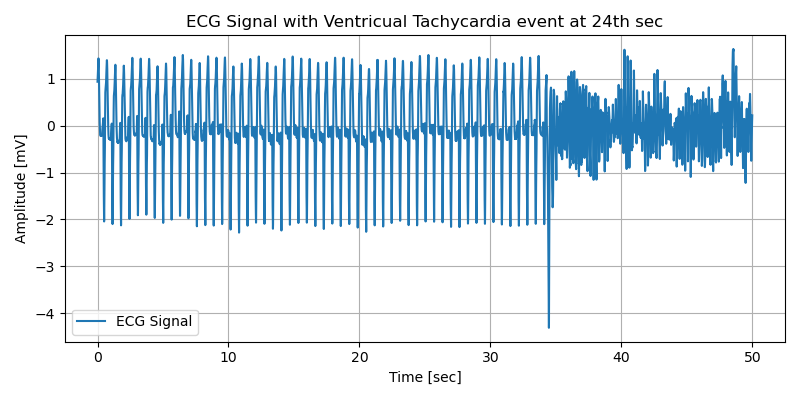

In [2]:
# Load and visualize input data
data = pd.read_csv("example_2_data.csv")

fs = 250  # Hz
N = data.shape[0]

# Create a time vector
time_vector = np.arange(0, N) / fs

# Plot ECG signal
plt.figure(figsize=(8, 4))
plt.plot(time_vector, data["ECG"], label="ECG Signal")
plt.title("ECG Signal with Ventricual Tachycardia event at 24th sec")
plt.xlabel("Time [sec]")
plt.ylabel("Amplitude [mV]")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

In [3]:
# Prepare data scaler and scale data for training
scaler = MinMaxScaler()
data_normalized = pd.DataFrame(scaler.fit_transform(data), columns=data.columns, index=data.index)

In [4]:
# Input data setup. The parameter and ny specify how many historic values from an input vector are be used
ny = 79
prediction_horizon = 1
N = data_normalized.shape[0]

X = np.ones((N, 1 + ny))  # On the first position we will keep bias
y = np.zeros((N,))

# Generate X, y dynamically based on 'ny'
for k in range(ny, N - prediction_horizon):
    X[k, 1:] = data_normalized["ECG"][k - ny : k][::1]
    y[k] = data_normalized["ECG"][k + prediction_horizon - 1]

X = X[ny:-prediction_horizon, :]
y = y[ny:-prediction_horizon]

In [6]:
# Train Neural Unit
mu = 0.01  # Learning rate
epochs = 5

# Initialize parameters
N = X.shape[0]
print(f"The total amount of samples: {N}.")
nw = X.shape[1]  # Get weights for neuron
r = 1  # Set the order of polynom
if r > 1:
    nw = math.ceil(math.factorial(nw + r - 1) / math.factorial(r) / math.factorial(nw - 1))
w = np.random.randn(nw) / nw
print(f"Total amount of trainable weights {nw}.")

# Holders for adaptation values
e = np.zeros(N)
yn = np.zeros(N)
wall = np.zeros((N, nw))

# Training Quadratic Neural Unit
for epoch in range(epochs):
    for k in range(N):
        # Prepare polynomial input vector
        if r > 1:
            outer_product = np.outer(X[k], X[k])
            upper_triangle = np.triu_indices_from(outer_product)
            x = outer_product[upper_triangle]
        else:
            x = X[k, :]

        yn[k] = np.dot(w, x)
        e[k] = y[k] - yn[k]

        dyndw = x  # Gradient

        # Update weights
        # Uncomment the desired weight update rule

        # Pure Gradient Descent (GD)
        # dw = mu * e[k] * dyndw

        # GD with normalization
        dw = mu / (sum(x * x)) * e[k] * dyndw  # x0=1 => division by zero is avoided

        # GD with normalization and momentum
        # dw = 0.2 * mu / (sum(x * x)) * e[k] * dyndw + 0.8 * dw

        w = w + dw  # Update weights
        wall[k, :] = w  # Store weights for analysis

    epoch_error = np.mean(e**2)
    print(f"Epoch {epoch+1} Mean Squared Error: {epoch_error}")

The total amount of samples: 12420.
Total amount of trainable weights 80.
Epoch 1 Mean Squared Error: 0.013605653216056699
Epoch 2 Mean Squared Error: 0.00666562696360025
Epoch 3 Mean Squared Error: 0.004597118657296133
Epoch 4 Mean Squared Error: 0.0035758886843478125
Epoch 5 Mean Squared Error: 0.00296617775034935


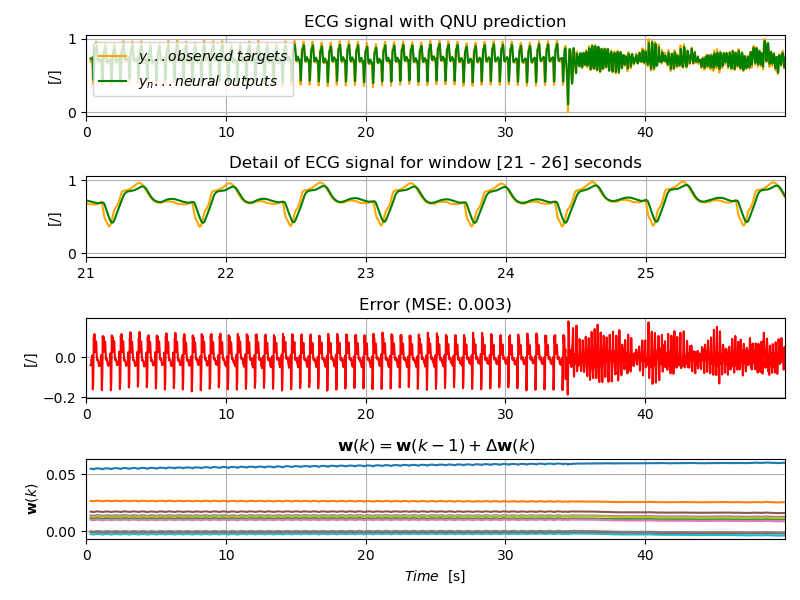

In [7]:
# Visualize model prediction
error = round(epoch_error, 3)
time_domain = np.arange(0, data.shape[0]) / fs
slice_start = 21
slice_end = 26


plt.figure(figsize=(8, 6))
# Plot observed target and neural output
ax1 = plt.subplot(411)
plt.title("ECG signal with QNU prediction")
plt.plot(time_domain[ny:-prediction_horizon], y, "orange", label=r"$y ... observed \ targets$")
plt.plot(time_domain[ny:-prediction_horizon], yn, "g", label=r"$y_n ... neural \ outputs$")
plt.ylabel("[/]")
plt.legend(loc="upper left")
plt.xlim(time_domain[0], time_domain[-1])
plt.grid()

# Plot detain of ECG signal
ax2 = plt.subplot(412)
plt.title(f"Detail of ECG signal for window [{slice_start} - {slice_end}] seconds")
sample_range = np.arange(slice_start * fs, slice_end * fs) / fs
plt.plot(time_domain[ny:-prediction_horizon], y, "orange", label=r"$y ... observed \ targets$")
plt.plot(time_domain[ny + prediction_horizon :], yn, "g", label=r"$y_n ... neural \ outputs$")
plt.ylabel("[/]")
plt.xlim(sample_range[0], sample_range[-1])
plt.grid()

# Plot error between observed targets and neural outputs
ax3 = plt.subplot(413, sharex=ax1)
plt.plot(time_domain[ny + prediction_horizon :], e, "r", label=r"$e=y-y_n$")
plt.title(f"Error (MSE: {error})")
plt.ylabel("[/]")
plt.grid()

# Plot weights adaptation
ax4 = plt.subplot(414, sharex=ax1)
plt.plot(time_domain[ny + prediction_horizon :], wall[:, :10]), plt.ylabel(r"$\mathbf{w}(k)$")
plt.title(r"$\mathbf{w}(k)=\mathbf{w}(k-1)+\Delta \mathbf{w}(k)$")
plt.grid()
plt.xlabel(r"$Time$  [s]")

plt.tight_layout()
plt.show()

## AISLE
In this part we will demonstrate usage of Learning Entropy on anomaly detection. As explained in [[1](https://www.researchgate.net/publication/257200647_Learning_Entropy_Multiscale_Measure_for_Incremental_Learning)] and further refined in [[2](https://www.researchgate.net/publication/331041954_Learning_Entropy_as_a_Learning-Based_Information_Concept)], Learning Entropy detects an anomaly by analyzing the weight updates of an neuron. The basic concept expects that once model is trained, the changes to weight updates should remain relatively similar over observed window of weights unless there is some novelty in data, which should be detected by Learning Entropy, as model needs more _energy_ to achieve new state.

### Execution time comparisson
For comparison of pythonic approach and JAX accelerated execution we provide naive time measurement approach within this notebook. Please do note, that once the code has been executed, next unchanged executions are usually cached and therefore invalid for any comparisons. As a fair comparison serves the window implementation, which is too big to remain cached.

#### Disclaimer
Measuring execution times within Jupyter Notebook always brings certain amount of error and is supposed to be taken as indicative and not absolute. Single AISLE evaluation places JAX accelerated LE to an disadvantege, as on its initial run the code has to be compiled. Repeated runs are then already accelerated. If evaluated data are too short or weight count is low, the compilation time of JAX takes usually longer than native implementation.


#### Sources
[1] I. Bukovsky, “Learning Entropy: Multiscale Measure for Incremental Learning,” Entropy, vol. 15, no. 10, pp. 4159–4187, Sep. 2013, doi: 10.3390/e15104159.

[2] I. Bukovsky, W. Kinsner, and N. Homma, “Learning Entropy as a Learning-Based Information Concept,” Entropy, vol. 21, no. 2, p. 166, Feb. 2019, doi: 10.3390/e21020166.

### AISLE - Single value retrieval

In [8]:
# Single AISLE value retrieval
oles = (1, 2)
alphas = (10, 15)

# Python single Learning Entropy evaluation
py_aisle_time = time.time()
py_aisle_value = py_aisle(wall, alphas=alphas, oles=oles)
py_aisle_time = time.time() - py_aisle_time

# JAX accelerated single Learning Entropy evaluation
jax_aisle_time = time.time()
jax_aisle_value = jax_aisle(wall, alphas=alphas, oles=oles)
jax_aisle_time = time.time() - jax_aisle_time

msg = (
    f"Single Learning Entropy evaluation with pythonic approach took: {py_aisle_time:.6f} seconds.\n",
    f"Single Learning Entropy evaluation with JAX aproach took: {jax_aisle_time:.6f} seconds.\n\n",
    "Single init evaluation with JAX is in general slower, as on its first run it has to compile parts of",
    " the code.\nRepeated usage is recommended.\n",
    "If reporting evaluation time is 0.000.., cache has been used and invalid time results are shown",
)
msg = "".join(text for text in msg)
print(msg)

Single Learning Entropy evaluation with pythonic approach took: 0.026611 seconds.
Single Learning Entropy evaluation with JAX aproach took: 0.605436 seconds.

Single init evaluation with JAX is in general slower, as on its first run it has to compile parts of the code.
Repeated usage is recommended.
If reporting evaluation time is 0.000.., cache has been used and invalid time results are shown


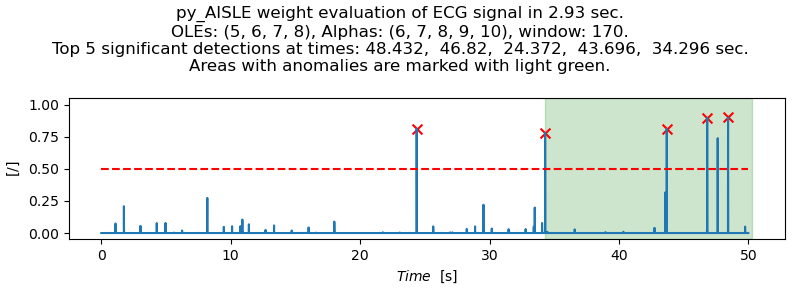

In [9]:
# AISLE setup
oles = (5, 6, 7, 8)  # Order of LE
alphas = (6, 7, 8, 9, 10)  # Sensitivity of evaluation
window = 170  # Window evaluated for each AISLE
threshold = 0.5  # Visual threshold (red dashed line)

# Sum, normalize and shift AISLE to correspond to original data
aisle_values = np.zeros(data.shape[0])
py_aisle_time = time.time()
py_aisle_values = py_aisle_window(window, wall, alphas, oles)
py_aisle_time = time.time() - py_aisle_time
aisle_values[ny:-prediction_horizon] = np.sum(py_aisle_values, axis=1) / len(oles)


# Sort all indices in descending order
all_sorted_indices = np.argsort(aisle_values)[::-1]  # Sort all indices in descending order

# Define the range within which indices are considered too close
proximity_range = 2

# Filter indices that are too close, preferring the one with the higher value
filtered_indices = []
for index in all_sorted_indices:
    if not any(abs(index - other_index) <= proximity_range for other_index in filtered_indices):
        filtered_indices.append(index)

# Now select the top N indices after filtering
N = 5  # Number of top indices to select
final_indices = filtered_indices[:N]

# Construct the plot title with the top three significant values
top_values_str = "times:" + ", ".join([f" {idx/fs}" for idx in final_indices])
plot_title = (
    f"py_AISLE weight evaluation of ECG signal in {py_aisle_time:.2f} sec.\n",
    f"OLEs: {oles}, Alphas: {alphas}, window: {window}.\n",
    f"Top 5 significant detections at {top_values_str} sec.\n",
    "Areas with anomalies are marked with light green.",
)
plot_title = "".join(text for text in plot_title)

roi_ranges = (34, time_domain[-1])

# Plotting
fig = plt.figure(figsize=(8, 3))
fig.suptitle(plot_title)
plt.plot(time_domain, aisle_values, label="AISLE")
plt.hlines([0.5], 0, aisle_values.shape[0] // fs, colors="red", linestyles="dashed")
plt.ylabel(r"$[/]$")
plt.xlabel(r"$Time$  [s]")

# Fill specified ROI ranges with green background
plt.fill_between(
    x=np.arange(roi_ranges[0] + ny / fs, roi_ranges[1] + 1), y1=-0.05, y2=1.05, color="green", alpha=0.2
)

# Places crosses on top indices
for index in final_indices:
    if index < len(aisle_values):  # Check to avoid indexing errors
        plt.scatter(index / fs, aisle_values[index], color="red", marker="x", s=50)

plt.ylim((-0.05, 1.05))
plt.tight_layout()
plt.show()

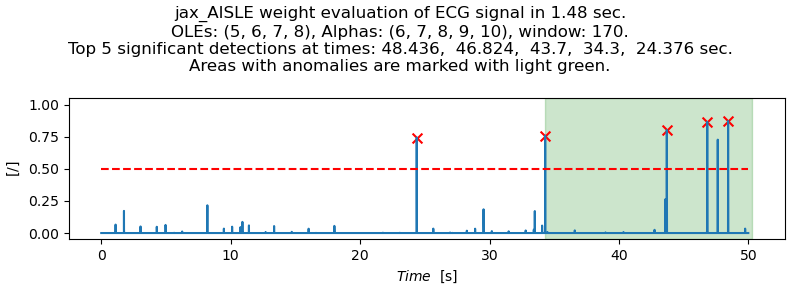

In [10]:
# AISLE setup
oles = (5, 6, 7, 8)  # Order of LE
alphas = (6, 7, 8, 9, 10)  # Sensitivity of evaluation
window = 170  # Window evaluated for each AISLE
threshold = 0.5  # Visual threshold (red dashed line)

# Sum, normalize and shift AISLE to correspond to original data
aisle_values = np.zeros(data.shape[0])
jax_aisle_time = time.time()
jax_aisle_values = jax_aisle_window(window, wall, alphas, oles)
jax_aisle_time = time.time() - jax_aisle_time
aisle_values[ny + prediction_horizon :] = np.sum(jax_aisle_values, axis=1) / len(oles)


# Sort all indices in descending order
all_sorted_indices = np.argsort(aisle_values)[::-1]  # Sort all indices in descending order

# Define the range within which indices are considered too close
proximity_range = 2

# Filter indices that are too close, preferring the one with the higher value
filtered_indices = []
for index in all_sorted_indices:
    if not any(abs(index - other_index) <= proximity_range for other_index in filtered_indices):
        filtered_indices.append(index)

# Now select the top N indices after filtering
N = 5  # Number of top indices to select
final_indices = filtered_indices[:N]

# Construct the plot title with the top three significant values
top_values_str = "times:" + ", ".join([f" {idx/fs}" for idx in final_indices])
plot_title = (
    f"jax_AISLE weight evaluation of ECG signal in {jax_aisle_time:.2f} sec.\n",
    f"OLEs: {oles}, Alphas: {alphas}, window: {window}.\n",
    f"Top 5 significant detections at {top_values_str} sec.\n",
    "Areas with anomalies are marked with light green.",
)
plot_title = "".join(text for text in plot_title)

roi_ranges = (34, time_domain[-1])

# Plotting
fig = plt.figure(figsize=(8, 3))
fig.suptitle(plot_title)
plt.plot(time_domain, aisle_values, label="AISLE")
plt.hlines([0.5], 0, aisle_values.shape[0] / fs, colors="red", linestyles="dashed")
plt.ylabel(r"$[/]$")
plt.xlabel(r"$Time$  [s]")

# Fill specified ROI ranges with green background
plt.fill_between(
    x=np.arange(roi_ranges[0] + ny / fs, roi_ranges[1] + 1), y1=-0.05, y2=1.05, color="green", alpha=0.2
)

# Places crosses on top indices
for index in final_indices:
    if index < len(aisle_values):  # Check to avoid indexing errors
        plt.scatter(index / fs, aisle_values[index], color="red", marker="x", s=50)

plt.ylim((-0.05, 1.05))
plt.tight_layout()
plt.show()

In [11]:
# AISLE with pythonic approach
%timeit -n100 -r25 py_aisle(wall, alphas=alphas, oles=oles)

29.6 ms ± 621 µs per loop (mean ± std. dev. of 25 runs, 100 loops each)


In [12]:
# AISLE with JAX accelerated approach
%timeit -n100 -r25 jax_aisle(wall, alphas=alphas, oles=oles)

12.5 ms ± 917 µs per loop (mean ± std. dev. of 25 runs, 100 loops each)


In [13]:
# AISLE window evaluation with pythonic approach
%timeit -n5 -r10 py_aisle_window(window, wall, alphas, oles)

2.82 s ± 69.3 ms per loop (mean ± std. dev. of 10 runs, 5 loops each)


In [14]:
# AISLE window evaluation with JAX accelerated approach
%timeit -n5 -r10 jax_aisle_window(window, wall, alphas, oles)

894 ms ± 17.8 ms per loop (mean ± std. dev. of 10 runs, 5 loops each)
